In [7]:
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.utils.data import DataLoader, Subset, ConcatDataset
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
import time
from tqdm import tqdm
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
print("---")
print(f"Est-ce que le GPU est prêt ? {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU : {torch.cuda.get_device_name(0)}")

---
Est-ce que le GPU est prêt ? True
GPU : Tesla T4


In [9]:
BATCH_SIZE = 64
checkpoint = torch.load("/kaggle/input/baseline-pneumonia-model/baseline_metrics.pt")
MEAN = checkpoint['mean']
STD = checkpoint['std']
# Tu récupères tes moyennes et écart-types pour que les images soient traitées pareil !

In [10]:
path = "/kaggle/input/chest-xray-pneumonia/chest_xray"

# Petit test pour être sûr que les dossiers sont là
if os.path.exists(path):
    print("✅ Dataset trouvé !")
    print("Dossiers disponibles :", os.listdir(path))
else:
    print("❌ Dataset non trouvé. Vérifie si tu as cliqué sur '+ Add Data' à droite.")

✅ Dataset trouvé !
Dossiers disponibles : ['chest_xray', '__MACOSX', 'val', 'test', 'train']


In [11]:
train_tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

val_test_tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

base_path = os.path.join(path, "chest_xray")
full_train = datasets.ImageFolder(os.path.join(base_path, "train"), transform=train_tf)
train_clean = datasets.ImageFolder(os.path.join(base_path, "train"), transform=val_test_tf)
test_dataset = datasets.ImageFolder(os.path.join(base_path, "test"), transform=val_test_tf)

indices = torch.randperm(len(full_train), generator=torch.Generator().manual_seed(42))
train_idx, val_idx = indices[:int(0.9*len(full_train))], indices[int(0.9*len(full_train)):]

train_loader = DataLoader(Subset(full_train, train_idx), batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(ConcatDataset([datasets.ImageFolder(os.path.join(base_path, "val"), transform=val_test_tf), 
                                       Subset(train_clean, val_idx)]), batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=2, 
    pin_memory=True
)

# Architecture baseline implémenté

In [12]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()
        
        # Bloc 1
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        
        # Bloc 2
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        
        # Bloc 3
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        # Calcul : 224 -> 112 -> 56 -> 28
        self.fc1 = nn.Linear(64 * 28 * 28, 128) 
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        
        x = x.view(x.size(0), -1) 
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [13]:
model = SimpleCNN().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

weights = torch.tensor([2.8, 1.0]).to(device) 
criterion = nn.CrossEntropyLoss(weight=weights)

writer = SummaryWriter('runs/pneumonia_baseline_1')

In [14]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Nombre de paramètres : {total_params:,}")
# On devrait être autour de 1.2M - 1.5M selon les tailles des FC.

Nombre de paramètres : 6,446,722


In [15]:
import matplotlib.pyplot as plt

def train_model_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, epochs=20, patience=5, min_delta=0):
    best_val_loss = float('inf')
    trigger_times = 0
    
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(epochs):
        model.train()
        running_loss, correct_train, total_train = 0.0, 0, 0
        
        print(f"\nÉpoque {epoch+1}/{epochs}")
        for images, labels in tqdm(train_loader, desc="Training"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            
        train_loss = running_loss / len(train_loader.dataset)
        train_acc = 100 * correct_train / total_train
        
        model.eval()
        running_val_loss, correct_val, total_val = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        
        val_loss = running_val_loss / len(val_loader.dataset)
        val_acc = 100 * correct_val / total_val
        
        history['train_loss'].append(train_loss); history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss); history['val_acc'].append(val_acc)
        
        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

        # --- LOGIQUE EARLY STOPPING AMÉLIORÉE ---
        # On vérifie si l'amélioration dépasse le min_delta
        if val_loss < (best_val_loss - min_delta):
            best_val_loss = val_loss
            trigger_times = 0
            torch.save(model.state_dict(), 'best_model.pth')
            print(f"✅ Amélioration significative ! Modèle sauvegardé.")
        else:
            trigger_times += 1
            print(f"⚠️ Pas d'amélioration notable ({trigger_times}/{patience})")
            print(f"   (Best Loss: {best_val_loss:.4f})")
            
            if trigger_times >= patience:
                print(f"🛑 STOP : Pas d'amélioration depuis {patience} époques.")
                break

    plot_training_curves(history)
    return history
    

def plot_training_curves(history):
    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'o-', label='Train')
    plt.plot(epochs, history['val_loss'], 'o-', label='Val')
    plt.title('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], 'o-', label='Train')
    plt.plot(epochs, history['val_acc'], 'o-', label='Val')
    plt.title('Accuracy (%)')
    plt.legend()
    
    plt.show()


Époque 1/30


Training: 100%|██████████| 74/74 [00:51<00:00,  1.44it/s]


Train Loss: 1.7419 | Val Loss: 0.1606 | Val Acc: 95.35%
✅ Amélioration significative ! Modèle sauvegardé.

Époque 2/30


Training: 100%|██████████| 74/74 [00:37<00:00,  1.96it/s]


Train Loss: 0.1972 | Val Loss: 0.1040 | Val Acc: 95.17%
✅ Amélioration significative ! Modèle sauvegardé.

Époque 3/30


Training: 100%|██████████| 74/74 [00:37<00:00,  1.97it/s]


Train Loss: 0.1809 | Val Loss: 0.0956 | Val Acc: 95.72%
✅ Amélioration significative ! Modèle sauvegardé.

Époque 4/30


Training: 100%|██████████| 74/74 [00:37<00:00,  1.95it/s]


Train Loss: 0.1508 | Val Loss: 0.0758 | Val Acc: 96.10%
✅ Amélioration significative ! Modèle sauvegardé.

Époque 5/30


Training: 100%|██████████| 74/74 [00:38<00:00,  1.94it/s]


Train Loss: 0.1456 | Val Loss: 0.0856 | Val Acc: 97.21%
⚠️ Pas d'amélioration notable (1/7)
   (Best Loss: 0.0758)

Époque 6/30


Training: 100%|██████████| 74/74 [00:37<00:00,  1.95it/s]


Train Loss: 0.1397 | Val Loss: 0.1119 | Val Acc: 96.47%
⚠️ Pas d'amélioration notable (2/7)
   (Best Loss: 0.0758)

Époque 7/30


Training: 100%|██████████| 74/74 [00:37<00:00,  1.96it/s]


Train Loss: 0.1308 | Val Loss: 0.0881 | Val Acc: 97.03%
⚠️ Pas d'amélioration notable (3/7)
   (Best Loss: 0.0758)

Époque 8/30


Training: 100%|██████████| 74/74 [00:38<00:00,  1.93it/s]


Train Loss: 0.1334 | Val Loss: 0.0774 | Val Acc: 96.28%
⚠️ Pas d'amélioration notable (4/7)
   (Best Loss: 0.0758)

Époque 9/30


Training: 100%|██████████| 74/74 [00:43<00:00,  1.71it/s]


Train Loss: 0.1123 | Val Loss: 0.0880 | Val Acc: 95.17%
⚠️ Pas d'amélioration notable (5/7)
   (Best Loss: 0.0758)

Époque 10/30


Training: 100%|██████████| 74/74 [00:45<00:00,  1.64it/s]


Train Loss: 0.1184 | Val Loss: 0.1291 | Val Acc: 94.24%
⚠️ Pas d'amélioration notable (6/7)
   (Best Loss: 0.0758)

Époque 11/30


Training: 100%|██████████| 74/74 [00:47<00:00,  1.55it/s]


Train Loss: 0.1050 | Val Loss: 0.0802 | Val Acc: 96.65%
⚠️ Pas d'amélioration notable (7/7)
   (Best Loss: 0.0758)
🛑 STOP : Pas d'amélioration depuis 7 époques.


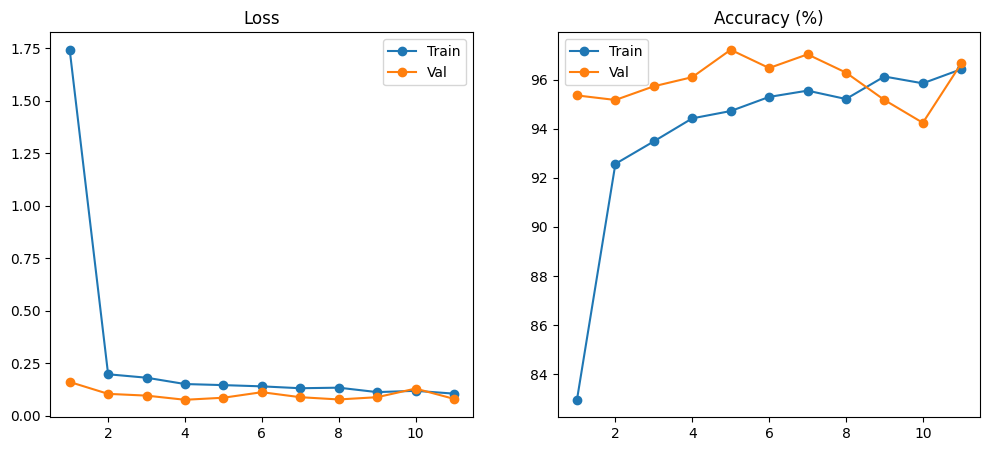

In [16]:
# 1. Reset du modèle (Crucial !)
model = SimpleCNN().to(device)

# 2. Reset de l'optimiseur
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 3. Reset du critère
weights = torch.tensor([2.8, 1.0]).to(device)
criterion = nn.CrossEntropyLoss(weight=weights)

history = train_model_with_early_stopping(
    model, 
    train_loader, 
    val_loader, 
    criterion, 
    optimizer, 
    epochs=30, 
    patience=7,      # Plus tolérant
    min_delta=0.001  # Doit s'améliorer d'au moins 0.001 pour reset le compteur
)

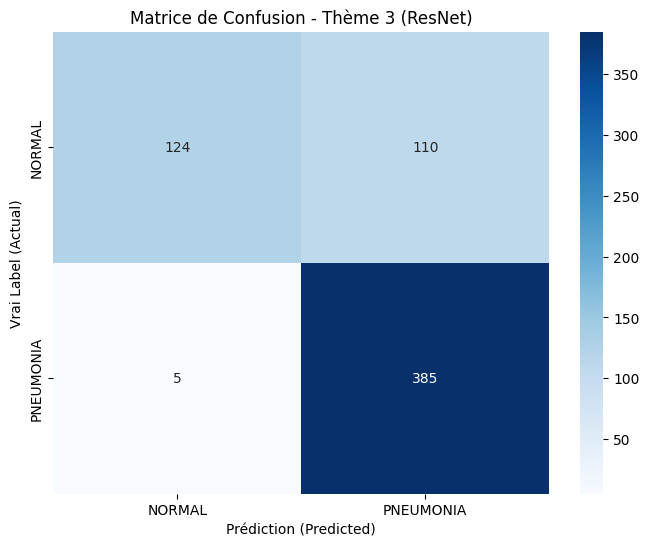


--- Rapport de Classification ---
              precision    recall  f1-score   support

      NORMAL       0.96      0.53      0.68       234
   PNEUMONIA       0.78      0.99      0.87       390

    accuracy                           0.82       624
   macro avg       0.87      0.76      0.78       624
weighted avg       0.85      0.82      0.80       624



In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

def test_model_visual(model, test_loader, device=device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # 1. Calcul de la matrice
    cm = confusion_matrix(all_labels, all_preds)
    class_names = ['NORMAL', 'PNEUMONIA'] # L'ordre dépend de tes dossiers

    # 2. Affichage graphique
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    
    plt.title('Matrice de Confusion - Thème 3 (ResNet)')
    plt.ylabel('Vrai Label (Actual)')
    plt.xlabel('Prédiction (Predicted)')
    plt.show()

    # 3. Rapport de classification classique
    print("\n--- Rapport de Classification ---")
    print(classification_report(all_labels, all_preds, target_names=class_names))

# Lancement
test_model_visual(model, test_loader)